In [3]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 869514981400639843, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1591678868062907287
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 18250355489776762950
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 111017984
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13118830924506075564
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [4]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy


smooth = 1e-9

# This is the competition metric implemented using Keras
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * (K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

# We'll construct a Keras Loss that incorporates the DICE score
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1. - (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)


def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

"""
# Create simple model
from keras.layers import Conv2D, Reshape
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(64, 5, activation='relu', padding='same', input_shape=(128, 128, 3)))
model.add(Conv2D(128, 5, activation='relu', padding='same'))
model.add(Conv2D(1, 5, activation='sigmoid', padding='same'))
model.add(Reshape((128, 128)))
          
model.compile(Adam(lr=0.01), loss=bce_dice_loss, metrics=[dice_coef])     
"""


def unet(input_size = (512,512,3)):
    inputs = Input(input_size)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu',  padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu',  padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu',  padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu',  padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='relu',  padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu',  padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='relu',  padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu',  padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='relu',  padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu',  padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='relu',  padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu',  padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='relu',  padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu',  padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='relu',  padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    
    outputs = Reshape((512,512))(outputs)
    
    model = Model(input = inputs, output = outputs)
    
    

    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.compile(Adam(lr=1e-3), loss=bce_dice_loss, metrics=[dice_coef])
    #smaller learning rate seems to work better (1e-4 vs 1e-2)
    
    return model



In [5]:
from glob import glob
import os

path_to_train = 'train'
glob_train_imgs = os.path.join(path_to_train, '*_sat.jpg')
glob_train_masks = os.path.join(path_to_train, '*_msk.png')

train_img_paths = glob(glob_train_imgs)
train_mask_paths = glob(glob_train_masks)
print(train_img_paths[:10])
print(train_mask_paths[:10])
print (len(train_img_paths))

path_to_val = 'val'
glob_val_imgs = os.path.join(path_to_val, '*_sat.jpg')
val_img_paths = glob(glob_val_imgs)
print(val_img_paths[:5])

['train/10729_sat.jpg', 'train/51187_sat.jpg', 'train/52299_sat.jpg', 'train/4962_sat.jpg', 'train/13549_sat.jpg', 'train/15363_sat.jpg', 'train/38456_sat.jpg', 'train/50517_sat.jpg', 'train/32252_sat.jpg', 'train/12993_sat.jpg']
['train/12895_msk.png', 'train/23379_msk.png', 'train/19799_msk.png', 'train/2575_msk.png', 'train/50807_msk.png', 'train/41694_msk.png', 'train/9457_msk.png', 'train/34365_msk.png', 'train/47347_msk.png', 'train/21599_msk.png']
10897
['val/70036_sat.jpg', 'val/75729_sat.jpg', 'val/78249_sat.jpg', 'val/76288_sat.jpg', 'val/71029_sat.jpg']


In [6]:
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

# This will be useful so we can construct the corresponding mask
def get_img_id(img_path):
    img_basename = os.path.basename(img_path)
    img_id = os.path.splitext(img_basename)[0][:-len('_sat')]
    return img_id

# Write it like a normal function
def image_gen(img_paths, img_size=(512, 512)):
    # Iterate over all the image paths
    for img_path in img_paths:
        
        # Construct the corresponding mask path
        img_id = get_img_id(img_path)
        mask_path = os.path.join(path_to_train, img_id + '_msk.png')
        
        # Load the image and mask, and normalize it to 0-1 range
        img = imread(img_path) #/ 255.
        mask = rgb2gray(imread(mask_path))
        
        # Resize the images
        img = resize(img, img_size, preserve_range=True)
        mask = resize(mask, img_size, mode='constant', preserve_range=True)
        # Turn the mask back into a 0-1 mask
        mask = (mask >= 0.5).astype(float)
        
        # Yield the image mask pair
        yield img, mask

In [30]:
%matplotlib inline
import collections
import mxnet as mx # used version '1.0.0' at time of writing
from mxnet.gluon.data import dataset
import os
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

def horizontal_augmentation(joint):
    aug = mx.image.HorizontalFlipAug(1)
    joint = mx.nd.array(joint)
    aug_joint = aug(joint)
    return aug_joint.asnumpy()

def vertical_augmentation(joint):  
    joint = np.flipud(joint)   
    return joint
      

def rotate_augmentation(joint):
    joint = np.rot90(joint)
    return joint
    
def brightness_augmentation(base): #changes brightness
    # Only applied to the base image, and not the mask layers.
    aug = mx.image.BrightnessJitterAug(brightness=.5)
    base = mx.nd.array(base)
    aug_base = aug(base)
    # Add more color augmentations here...
    aug_base = aug_base.astype('int')
    return aug_base.asnumpy()


def horizontal_transform(base, mask): #horizontal flip
    ### Convert types
    base = base.astype('float')
    mask = mask.astype('float')
  

    ### Join
    # Concatinate on channels dim, to obtain an 6 channel image
    # (3 channels for the base image, plus 3 channels for the mask)
    base_channels = base.shape[2] # so we know where to split later on
    joint = np.dstack((base, mask.reshape((512,512,1))))
    #joint = mx.nd.concat(base, mask, dim=2)
    #print (joint.shape)

    ### Augmentation Part 1: positional
    aug_joint = horizontal_augmentation(joint)
    
    ### Split
    aug_base = aug_joint[:, :, :base_channels]
    aug_mask = aug_joint[:, :, base_channels:]
    
    aug_base = resize(aug_base, (512,512), mode='constant', preserve_range=True).astype('int')
    aug_mask = resize(aug_mask, (512,512), mode='constant', preserve_range=True).reshape((512,512)).astype('int')
    return aug_base, aug_mask

def vertical_transform(base, mask): #vertical flip
    ### Convert types
    base = base.astype('float')
    mask = mask.astype('float')
  

    ### Join
    # Concatinate on channels dim, to obtain an 6 channel image
    # (3 channels for the base image, plus 3 channels for the mask)
    base_channels = base.shape[2] # so we know where to split later on
    joint = np.dstack((base, mask.reshape((512,512,1))))
    #joint = mx.nd.concat(base, mask, dim=2)
    #print (joint.shape)

    ### Augmentation Part 1: positional
    aug_joint = vertical_augmentation(joint)
    
    ### Split
    aug_base = aug_joint[:, :, :base_channels]
    aug_mask = aug_joint[:, :, base_channels:]
    
    aug_base = resize(aug_base, (512,512), mode='constant', preserve_range=True).astype('int')
    aug_mask = resize(aug_mask, (512,512), mode='constant', preserve_range=True).reshape((512,512)).astype('int')
    return aug_base, aug_mask

def rotate_transform(base,mask): #90 degree rotation
     ### Convert types
    base = base.astype('float')
    mask = mask.astype('float')
  

    ### Join
    # Concatinate on channels dim, to obtain an 6 channel image
    # (3 channels for the base image, plus 3 channels for the mask)
    base_channels = base.shape[2] # so we know where to split later on
    joint = np.dstack((base, mask.reshape((512,512,1))))
    #joint = mx.nd.concat(base, mask, dim=2)
    #print (joint.shape)

    ### Augmentation Part 1: positional
    aug_joint = rotate_augmentation(joint)
    
    ### Split
    aug_base = aug_joint[:, :, :base_channels]
    aug_mask = aug_joint[:, :, base_channels:]
    
    aug_base = resize(aug_base, (512,512), mode='constant', preserve_range=True).astype('int')
    aug_mask = resize(aug_mask, (512,512), mode='constant', preserve_range=True).reshape((512,512)).astype('int')
    return aug_base, aug_mask
    

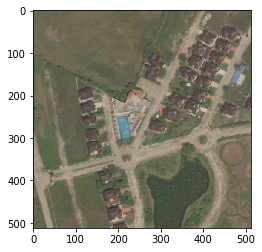

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


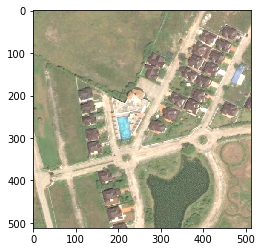

In [34]:
import matplotlib.pyplot as plt
original = imread(train_img_paths[1023])
img_id = get_img_id(train_img_paths[1023])
mask_path = os.path.join(path_to_train, img_id + '_msk.png')
        

mask = imread(mask_path, as_gray=True)

aug = brightness_augmentation(original.astype('float'))

plt.imshow(original)
plt.show()

plt.imshow(aug)
plt.show()

(512, 512, 3) (512, 512)


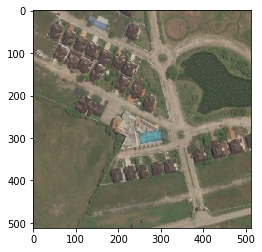

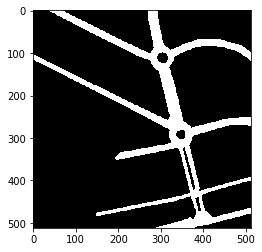

In [35]:
joint1, joint2 = rotate_transform(original,mask)
print (joint1.shape, joint2.shape)
plt.imshow(joint1)
plt.show()
plt.imshow(joint2, cmap='gray')
plt.show()



(512, 512, 3) (512, 512)


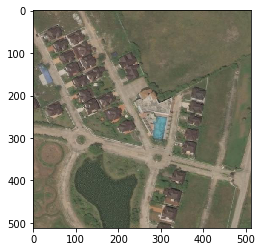

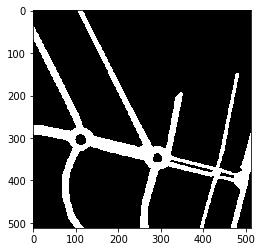

In [36]:
joint1, joint2 = horizontal_transform(original,mask)
print (joint1.shape, joint2.shape)
plt.imshow(joint1)
plt.show()
plt.imshow(joint2, cmap='gray')
plt.show()


(512, 512, 3) (512, 512)


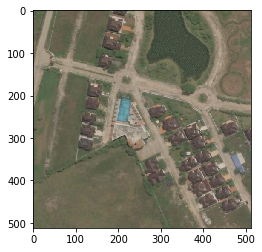

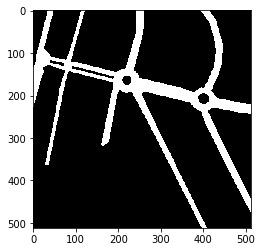

In [38]:
joint1, joint2 = vertical_transform(original,mask)
print (joint1.shape, joint2.shape)
plt.imshow(joint1)
plt.show()
plt.imshow(joint2, cmap='gray')
plt.show()


In [40]:
from random import shuffle
import cv2

shuffle(train_img_paths)

for i in range(len(train_img_paths[:1000])): #take 1000 random pics (after shuffling)
    path = 'train'
    original = imread(train_img_paths[i])
    img_id = get_img_id(train_img_paths[i])
    mask_path = os.path.join(path_to_train, img_id + '_msk.png')
    mask = imread(mask_path, as_gray=True)
    #change brightness
    aug = brightness_augmentation(original.astype('float'))
    cv2.imwrite(os.path.join(path , 'brightness'+ str(i) + '_sat.jpg'), aug) 
    cv2.imwrite(os.path.join(path , 'brightness' + str(i) + '_msk.png'), mask)
    #rotate
    joint1, joint2 = rotate_transform(original,mask)

    cv2.imwrite(os.path.join(path , 'rotation'+ str(i) + '_sat.jpg'),joint1)
    cv2.imwrite(os.path.join(path , 'rotation' + str(i) + '_msk.png'),joint2)
    #horizontal
    joint3, joint4 = horizontal_transform(original,mask)

    cv2.imwrite(os.path.join(path , 'horizontal'+ str(i) + '_sat.jpg'),joint3)
    cv2.imwrite(os.path.join(path , 'horizontal' + str(i) + '_msk.png'),joint4)
    #vertical
    joint5, joint6 = vertical_transform(original,mask)

    cv2.imwrite(os.path.join(path , 'vertical'+ str(i) + '_sat.jpg'),joint5)
    cv2.imwrite(os.path.join(path , 'vertical' + str(i) + '_msk.png'),joint6)
    

KeyboardInterrupt: 

In [44]:
model = unet()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 512, 512, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 16) 2320        dropout_1[0][0]                  
__________________________________________________________________________________________________
max_poolin

/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:107: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`


In [46]:
#compute average image

average = np.empty((512,512,3))
for i in range(len(train_img_paths)):
    img = imread(train_img_paths[i])
    average = np.add(average, img)
avg = average/14897 #now we have 14897 images

In [48]:
#compute standard deviation image

sd = np.empty((512,512,3))
for i in range(len(train_img_paths)):
    img = imread(train_img_paths[i])
    a = np.subtract(img, avg)
    a = np.square(a)
    sd = np.add(sd, a)
sd = sd/14897
sd = np.sqrt(sd)


In [49]:
print (sd)

[[[ 44.04168105  35.86412663  34.48480989]
  [ 42.75471076  72.1514004   60.27282942]
  [ 77.89492423  72.54046157  60.99236072]
  ..., 
  [ 77.98215365  72.54210474  60.99204675]
  [ 78.02926226  72.39026783  60.48987876]
  [ 78.27632147  72.50086682  60.38139975]]

 [[ 77.81420964  72.26510462  60.36047429]
  [ 77.57032931  72.26160773  60.70501905]
  [ 77.86840025  72.84258804  61.74089186]
  ..., 
  [ 78.17350667  73.11398142  62.05461082]
  [ 77.96700947  72.55694465  60.98977607]
  [ 77.94792663  72.31203549  60.39133194]]

 [[ 77.73766287  72.36776406  60.72597916]
  [ 77.74599875  72.74556509  61.59599439]
  [ 78.34518903  73.7768269   63.24148906]
  ..., 
  [ 78.62878978  74.04823349  63.61962714]
  [ 78.08882388  72.99926394  61.90287776]
  [ 77.8828107   72.4178612   60.82256067]]

 ..., 
 [[ 77.68678856  72.1492729   60.33659829]
  [ 77.79611183  72.61954005  61.33233687]
  [ 78.39701897  73.73131073  63.10645632]
  ..., 
  [ 77.86734771  73.19615743  62.61731076]
  [ 77.50

In [56]:
model = unet() #create new unet model
model.load_weights('unet.hdf5') #load model with pre-saved weights

/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:107: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`


In [57]:
import numpy as np

# Keras takes its input in batches 
# (i.e. a batch size of 32 would correspond to 32 images and 32 masks from the generator)
# The generator should run forever
def image_batch_generator(img_paths, batchsize=32):
    while True:
        ig = image_gen(img_paths)
        batch_img, batch_mask = [], []
        
        for img, mask in ig:
            # Add the image and mask to the batch
            img = np.divide((img - avg),sd) #0 mean, 1 var
            batch_img.append(img)
            batch_mask.append(mask)
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_img) == batchsize:
                yield np.stack(batch_img, axis=0), np.stack(batch_mask, axis=0)
                batch_img, batch_mask = [], []


In [55]:
from sklearn.model_selection import train_test_split
import keras.callbacks
BATCHSIZE = 32

# Split the data into a train and validation set
train_img_paths, val_img_paths = train_test_split(train_img_paths, test_size=0.01)

# Create the train and validation generators
traingen = image_batch_generator(train_img_paths, batchsize=BATCHSIZE)
valgen = image_batch_generator(val_img_paths, batchsize=BATCHSIZE)

def calc_steps(data_len, batchsize):
    return (data_len + batchsize - 1) // batchsize

# Calculate the steps per epoch
train_steps = calc_steps(len(train_img_paths), BATCHSIZE)
val_steps = calc_steps(len(val_img_paths), BATCHSIZE)

filepath="unet.hdf5"

checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', period=1)
callbacks_list = [checkpoint]
# Train the model
history = model.fit_generator(
    traingen, 
    steps_per_epoch=train_steps, 
    epochs= 20, # Change this to a larger number to train for longer
    validation_data=valgen, 
    validation_steps=val_steps, 
    verbose=1,
    max_queue_size=5, # Change this number based on memory restrictions
    callbacks = callbacks_list 
)

Epoch 1/20
  4/395 [..............................] - ETA: 14:11 - loss: 0.3112 - dice_coef: 0.7450

KeyboardInterrupt: 

In [58]:
import numpy as np
import pandas as pd

# Create submission DataFrame
def create_submission(csv_name, predictions_gen):
    """
    csv_name -> string for csv ("XXXXXXX.csv")
    predictions -> generator that yields a pair of id, prediction
    """
    sub = pd.DataFrame()
    ids = []
    encodings = []
    num_images = len(val_img_paths)
    for i in range(num_images):
        if (i+1) % (num_images//10) == 0:
            print(i, num_images)
        img_id, pred = next(predictions_gen)
        ids.append(img_id)
        #print (np.count_nonzero(pred == 1))
        encodings.append(rle_encoding(pred))
        
    sub['EncodedPixels'] = encodings
    sub['ImageId'] = ids
    sub.to_csv(csv_name, index=False)

# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    """
    x = numpyarray of size (height, width) representing the mask of an image
    if x[i,j] == 0:
        image[i,j] is not a road pixel
    if x[i,j] != 0:
        image[i,j] is a road pixel
    """
    dots = np.where(x.T.flatten() != 0)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): 
            run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [59]:

def generate_pixel_by_pixel_predictions_generator(val_paths):
    for img_path in val_paths:        
        img = imread(img_path)
        img = resize(img, (512, 512), preserve_range=True) 
        img = np.divide((img - avg),sd) #0 mean, 1 var
        y = model.predict(img.reshape(1,512,512,3))  
        y = (y >= 0.5).astype(float) #IMPORTANT- need this or you won't have 0 or 1 (because outputs are probabilities!!)
        yield get_img_id(img_path), y.reshape(512, 512)

In [ ]:
#create submission
tic = time.time()
create_submission("unet.csv", generate_pixel_by_pixel_predictions_generator(val_img_paths))
toc = time.time()
print(toc - tic)

NameError: name 'plot' is not defined

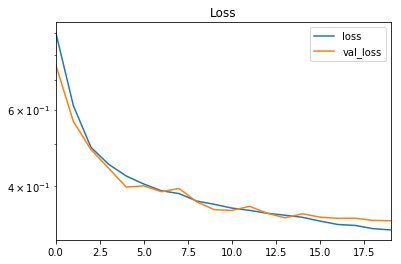

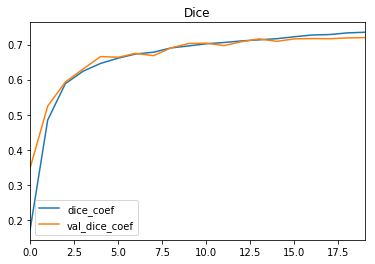

In [20]:
#rraining history
import pandas as pd
%matplotlib inline

# Plot the training curve
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(title="Loss", logy=True)
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot(title="Dice")
